In [134]:
# imports
import os
import shutil
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# %matplotlib notebook

In [96]:
# constants
EAGLE_ORFS_GTF_PATH = "NC_000913.fasta.gtf"
DEG_ESSENTIAL_GTF_PATH = "DEG1018_essential.gtf"
DEG_NONESSENTIAL_GTF_PATH = "DEG1018_nonessential.gtf"

In [128]:
# lib
def get_gtf_df(eagle_orfs_gtf_path, annot_gtf_path=None):
    gtf_df = pd.read_csv(eagle_orfs_gtf_path, sep="\t")
    gtf_df = gtf_df.merge(pd.DataFrame(list(gtf_df.apply(parse_attr_col, axis=1))))
    gtf_df["representation"] = 1.0 - gtf_df["representation"]
    gtf_df["uniformity_std"] = 1.0 - gtf_df["uniformity_std"] / gtf_df["uniformity_std"].max()
    if annot_gtf_path is not None:
        annot_gtf_df = pd.read_csv(annot_gtf_path, sep="\t", header=None)
        if tuple(annot_gtf_df.iloc[0]) == ("seqid", "source", "type", "start", "end", "score", "strand", "frame", "attribute"):
            annot_gtf_df = annot_gtf_df.drop(0).reset_index(drop=True)
        annot_gtf_df.columns = ("seqid", "source", "type", "start", "end", "score", "strand", "frame", "attribute")
        ori_gr = gtf_df.groupby(by="strand")
        annot_ori_gr = annot_gtf_df.groupby(by="strand")
        fwd_gtf_df = ori_gr.get_group("+").astype({"seqid": str, "start": int, "end": int})
        rev_gtf_df = ori_gr.get_group("-").astype({"seqid": str, "start": int, "end": int})
        fwd_gtf_df["annot_score"] = fwd_gtf_df.apply(detect_gtf_intersect, axis=1, args=(annot_ori_gr.get_group("+").astype({"seqid": str, "start": int, "end": int}),))
        rev_gtf_df["annot_score"] = rev_gtf_df.apply(detect_gtf_intersect, axis=1, args=(annot_ori_gr.get_group("-").astype({"seqid": str, "start": int, "end": int}),))
        gtf_df = merge_gtf_dfs(fwd_gtf_df, rev_gtf_df)
    return gtf_df


def merge_gtf_dfs(gtf_df1, gtf_df2):
    gtf_df = pd.concat((gtf_df1, gtf_df2))
    return gtf_df.sort_values(["seqid", "start"]).reset_index(drop=True)


def detect_gtf_intersect(row, inter_gtf_df):
    max_inter = 0.0
    query = 'seqid == "%s" & end >= %s & start <= %s' % (row["seqid"], row["start"], row["end"])
    for i, row_ in inter_gtf_df.query(query).iterrows():
        cur_inter = float(min(row["end"], row_["end"]) - max(row["start"], row_["start"]) + 1) / float(max(row["end"], row_["end"]) - min(row["start"], row_["start"]) + 1)
        if cur_inter > max_inter:
            max_inter = cur_inter
    return max_inter


def parse_attr_col(row):
    attr_dict = json.loads(row["attribute"])
    return {
        "seqid": row["seqid"],
        "uniformity_std": attr_dict["uniformity_std"],
        "phylo_diff": attr_dict["phylo_diff"],
        "ORF_l": row["end"] - row["start"] + 1,
        "representation": attr_dict["representation"],
        "relative_median_btax_dist": attr_dict["relative_median_btax_dist"],
        "relative_mean_btax_dist": attr_dict["relative_mean_btax_dist"],
        "relative_median_ORF_dist": attr_dict["relative_median_ORF_dist"],
        "relative_mean_ORF_dist": attr_dict["relative_mean_ORF_dist"],
        "Ka/Ks": attr_dict["Ka/Ks"],
        "n_seqs_with_stops": attr_dict["n_seqs_with_stops"],
        "stops_per_seq_median": attr_dict["stops_per_seq_median"],
    }


def get_annot_group(row):
    if row["annot_ess"] >= 0.75:
        return "essential"
    if row["annot_noness"] >= 0.75:
        return "advantageous"
    else:
        return "other"

In [132]:
gtf_df_ess = get_gtf_df(EAGLE_ORFS_GTF_PATH, DEG_ESSENTIAL_GTF_PATH)
gtf_df_noness = get_gtf_df(EAGLE_ORFS_GTF_PATH, DEG_NONESSENTIAL_GTF_PATH)
gtf_df = gtf_df_ess[list(gtf_df_ess.columns)[:-1]]
gtf_df["annot_ess"], gtf_df["annot_noness"] = gtf_df_ess["annot_score"], gtf_df_noness["annot_score"]
gtf_df["annot_group"] = gtf_df.apply(get_annot_group, axis=1)
# nona_gtf_df = gtf_df.dropna()

In [140]:
gtf_df.head(15)

,seqid,source,type,start,end,score,strand,frame,attribute,Ka/Ks,...,relative_mean_ORF_dist,relative_mean_btax_dist,relative_median_ORF_dist,relative_median_btax_dist,representation,stops_per_seq_median,uniformity_std,annot_ess,annot_noness,annot_group
0,NC_000913.3|:1001780-1002874,EAGLE,ORF,1001780,1002874,-,+,.,"{""phylo_diff"": 1.0, ""relative_mean_ORF_dist"": ...",0.064077,...,0.210357,0.239310,0.245562,0.272869,0.723404,0.0,0.318340,0.0,0.0,other
1,NC_000913.3|:1002874-1003428,EAGLE,ORF,1002874,1003428,-,+,.,"{""phylo_diff"": 0.8823529411764706, ""relative_m...",0.132797,...,5.606487,7.651752,0.208233,0.322899,0.574468,0.0,0.557023,0.0,0.0,other
2,NC_000913.3|:1003322-1003951,EAGLE,ORF,1003322,1003951,-,+,.,"{""phylo_diff"": 0.9, ""relative_mean_ORF_dist"": ...",0.247191,...,15.795217,15.531763,20.406707,21.277008,0.510638,0.0,0.684199,0.0,0.0,other
3,NC_000913.3|:1003920-1004654,EAGLE,ORF,1003920,1004654,-,+,.,"{""phylo_diff"": 0.9285714285714286, ""relative_m...",0.239734,...,18.000436,18.705517,22.809773,23.080806,0.340426,0.0,0.781284,0.0,0.0,other
4,NC_000913.3|:1004729-1005775,EAGLE,ORF,1004729,1005775,-,+,.,"{""phylo_diff"": 0.75, ""relative_mean_ORF_dist"":...",0.030462,...,2.054004,3.352412,1.063257,2.051713,0.085106,0.0,0.495846,0.0,0.0,other
5,NC_000913.3|:1005898-1006491,EAGLE,ORF,1005898,1006491,-,+,.,"{""phylo_diff"": 0.7837837837837838, ""relative_m...",0.061512,...,3.437107,5.149918,3.036153,4.243696,0.148936,0.0,0.426798,0.0,0.0,other
6,NC_000913.3|:1007170-1007571,EAGLE,ORF,1007170,1007571,-,+,.,"{""phylo_diff"": 0.8108108108108109, ""relative_m...",0.174401,...,4.301726,6.412111,5.496500,6.296018,0.148936,1.0,0.713503,0.0,0.0,other
7,NC_000913.3|:100762-102237,EAGLE,ORF,100762,102237,-,+,.,"{""phylo_diff"": 0.6666666666666666, ""relative_m...",0.035712,...,2.519533,4.224936,1.040728,2.824593,0.042553,0.0,0.749614,0.0,0.0,other
8,NC_000913.3|:1007829-1009949,EAGLE,ORF,1007829,1009949,-,+,.,"{""phylo_diff"": 0.717948717948718, ""relative_me...",0.060849,...,2.734115,4.293815,1.676371,2.789678,0.106383,0.0,0.578099,0.0,0.0,other
9,NC_000913.3|:1009913-1011868,EAGLE,ORF,1009913,1011868,-,+,.,"{""phylo_diff"": 0.9743589743589743, ""relative_m...",0.223622,...,22.090140,14.422106,28.160029,17.902528,0.106383,0.0,1.000000,0.0,0.0,other


<IPython.core.display.Javascript object>


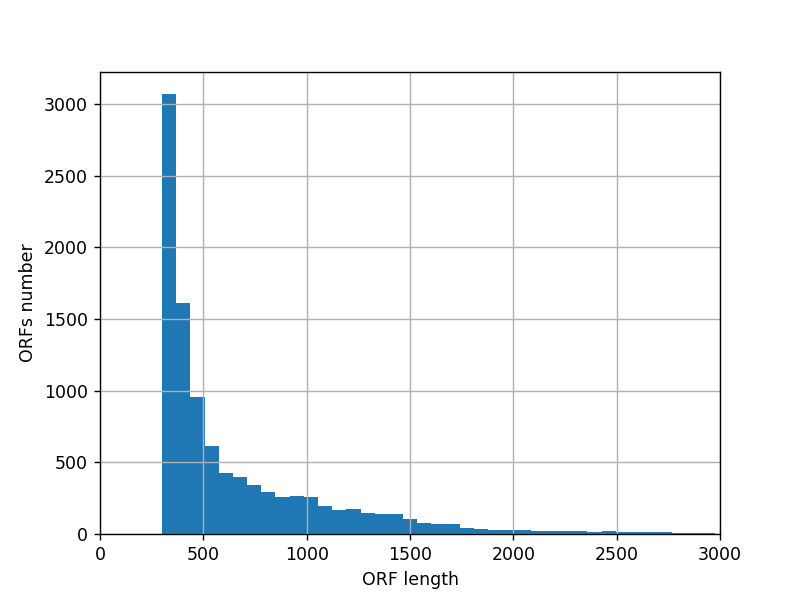

Text(0,0.5,'ORFs number')

In [98]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["ORF_l"])).hist(bins=100);
ax.set_xlabel("ORF length")
ax.set_xlim(0, 3000)
ax.set_ylabel("ORFs number")

<IPython.core.display.Javascript object>


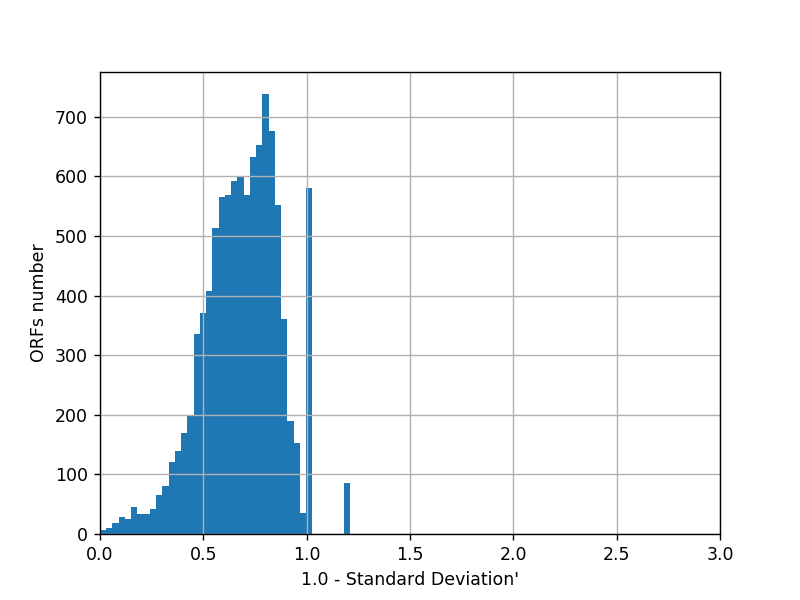

Text(0,0.5,'ORFs number')

In [126]:
ax = gtf_df["uniformity_std"].hist(bins=40)
ax.set_xlabel("1.0 - Standard Deviation'")
ax.set_xlim(0, 3)
ax.set_ylabel("ORFs number")

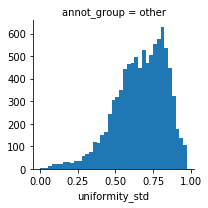

In [136]:
%matplotlib inline
bins = np.arange(0.0, 1.0, 0.025)
h = sns.FacetGrid(gtf_df, row="annot_group")
h.map(plt.hist, "uniformity_std", bins=bins)

<IPython.core.display.Javascript object>


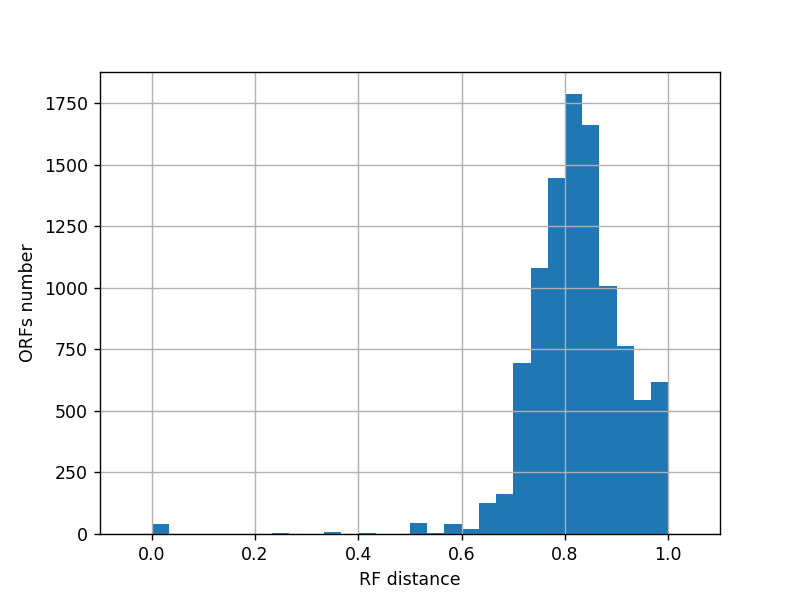

Text(0,0.5,'ORFs number')

In [103]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["phylo_diff"])).hist(bins=60);
ax.set_xlabel("RF distance")
ax.set_xlim(-0.1, 1.1)
ax.set_ylabel("ORFs number")

<IPython.core.display.Javascript object>


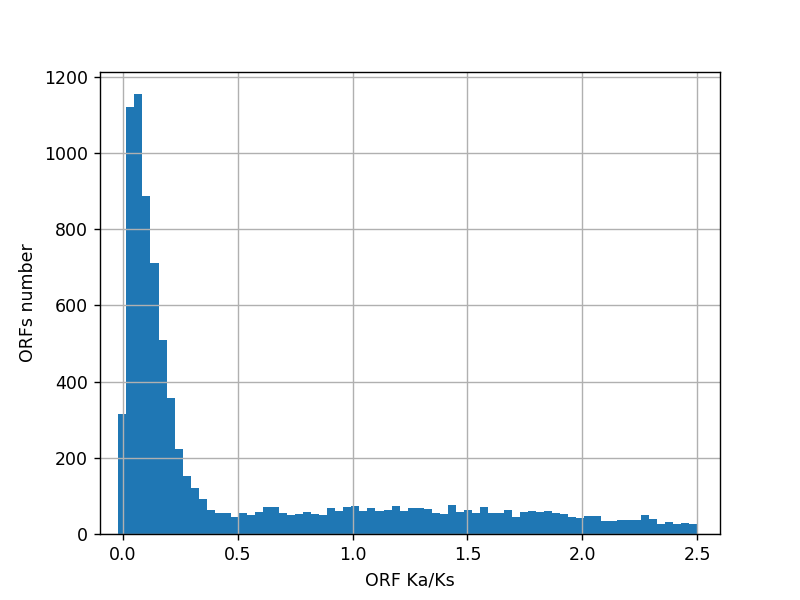

Text(0,0.5,'ORFs number')

In [104]:
ax = pd.Series(filter(lambda x: not np.isnan(x) and x <= 2.5, gtf_df["Ka/Ks"])).hist(bins=100);
ax.set_xlabel("ORF Ka/Ks")
ax.set_xlim(-0.1, 2.6)
ax.set_ylabel("ORFs number")

Text(0,0.5,'ORFs number')

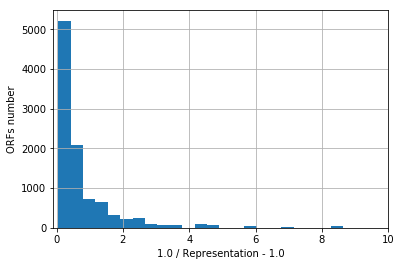

In [50]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["representation"])).hist(bins=60);
ax.set_xlabel("1.0 / Representation - 1.0")
ax.set_xlim(-0.1, 10.0)
ax.set_ylabel("ORFs number")

Text(0,0.5,'ORFs number')

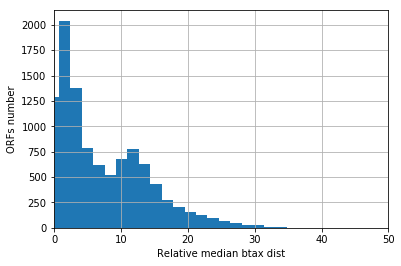

In [25]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["relative_median_btax_dist"])).hist(bins=45);
ax.set_xlabel("Relative median btax dist")
ax.set_xlim(-0.1, 50.0)
ax.set_ylabel("ORFs number")

Text(0,0.5,'RF distance')

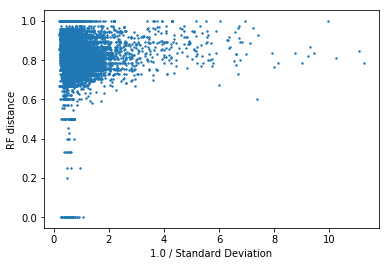

In [26]:
plt.scatter(x=nona_gtf_df["uniformity_std"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("RF distance")

Text(0,0.5,'ORF length')

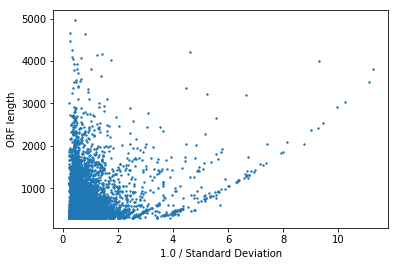

In [27]:
plt.scatter(x=gtf_df["uniformity_std"],
            y=gtf_df["ORF_l"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("ORF length")

Text(0,0.5,'RF distance')

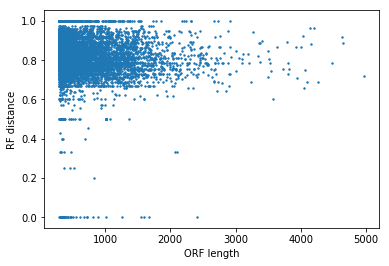

In [28]:
plt.scatter(x=nona_gtf_df["ORF_l"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("ORF length")
plt.ylabel("RF distance")

Text(0,0.5,'RF distance')

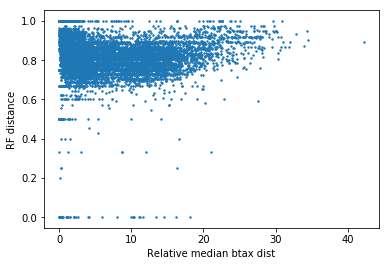

In [29]:
plt.scatter(x=nona_gtf_df["relative_median_btax_dist"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("Relative median btax dist")
plt.ylabel("RF distance")

Text(0,0.5,'1.0 / Representation - 1.0')

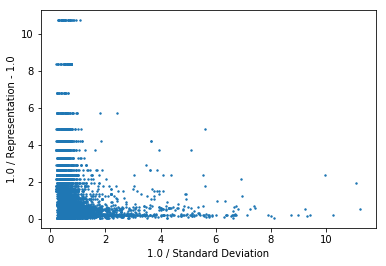

In [30]:
plt.scatter(x=nona_gtf_df["uniformity_std"],
            y=nona_gtf_df["representation"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("1.0 / Representation - 1.0")

Text(0,0.5,'Relative median btax dist')

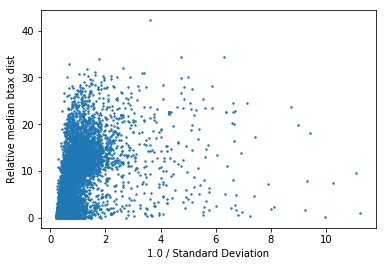

In [32]:
plt.scatter(x=gtf_df["uniformity_std"],
            y=gtf_df["relative_median_btax_dist"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("Relative median btax dist")

Text(0,0.5,'RF distance')

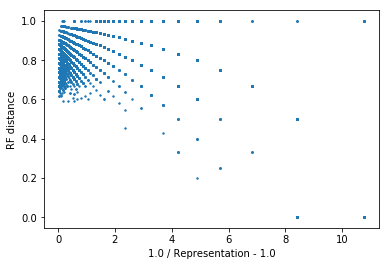

In [33]:
plt.scatter(x=nona_gtf_df["representation"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("1.0 / Representation - 1.0")
plt.ylabel("RF distance")

<IPython.core.display.Javascript object>


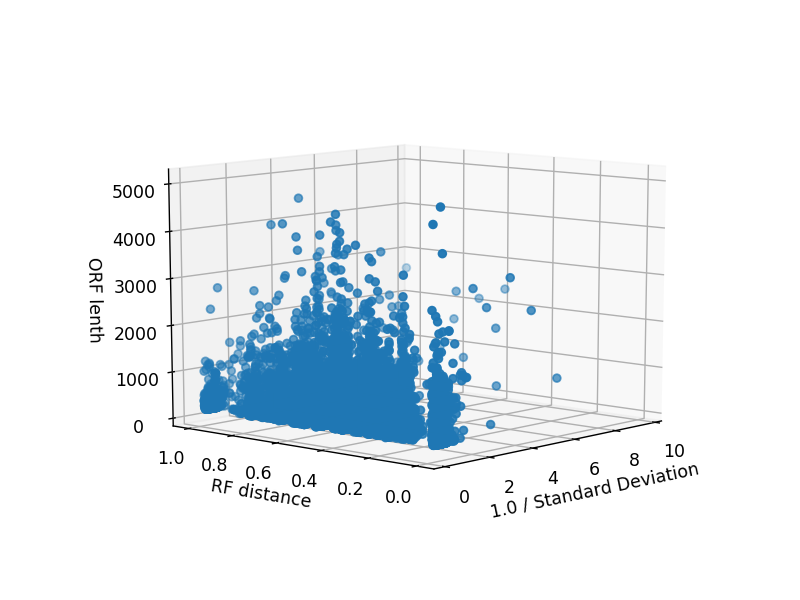

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nona_gtf_df["uniformity_std"],
           nona_gtf_df["phylo_diff"],
           nona_gtf_df["ORF_l"])
ax.set_xlabel("1.0 / Standard Deviation")
ax.set_ylabel("RF distance")
ax.set_zlabel("ORF lenth")
plt.show()

(2372, 14)


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


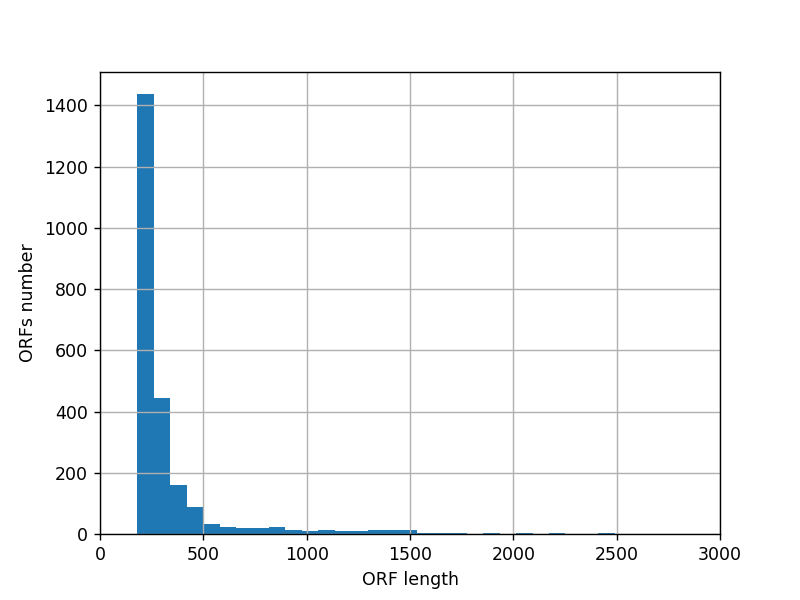

Text(0,0.5,'ORFs number')

In [109]:
gtf_df_filt1 = nona_gtf_df[nona_gtf_df["phylo_diff"] < 0.05][nona_gtf_df["uniformity_std"] < 2.0]
print(gtf_df_filt1.shape)
ax = gtf_df_filt1["ORF_l"].hist(bins=60)
ax.set_xlabel("ORF length")
ax.set_xlim(0, 3000)
ax.set_ylabel("ORFs number")

<IPython.core.display.Javascript object>


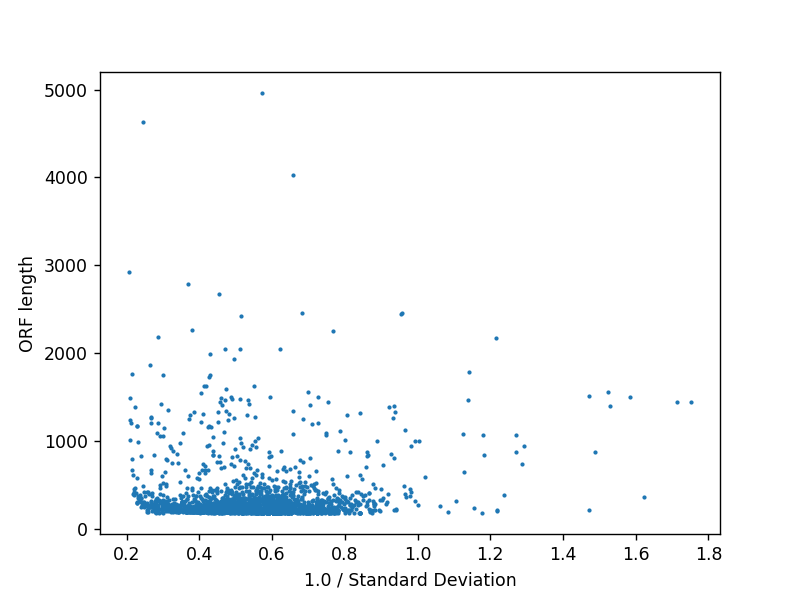

Text(0,0.5,'ORF length')

In [110]:
plt.scatter(x=gtf_df_filt1["uniformity_std"],
            y=gtf_df_filt1["ORF_l"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("ORF length")

Text(0,0.5,'1.0 / Representation - 1.0')

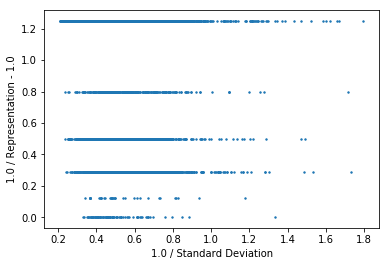

In [27]:
plt.scatter(x=gtf_df_filt["uniformity_std"],
            y=gtf_df_filt["representation"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("1.0 / Representation - 1.0")

(1080, 14)


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


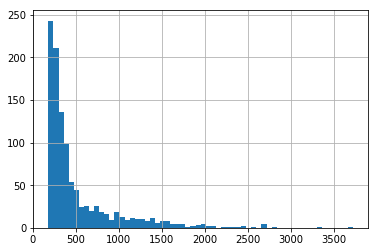

In [58]:
gtf_df_filt2 = gtf_df_filt[gtf_df_filt["representation"] < 0.4][gtf_df_filt["uniformity_std"] <= 1.3]
print(gtf_df_filt2.shape)
gtf_df_filt2["ORF_l"].hist(bins=60)

Text(0,0.5,'Relative median btax dist')

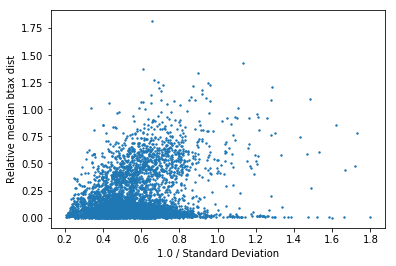

In [59]:
plt.scatter(x=gtf_df_filt["uniformity_std"],
            y=gtf_df_filt["relative_median_btax_dist"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("Relative median btax dist")

(447, 14)


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


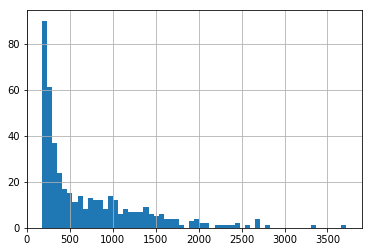

In [61]:
gtf_df_filt3 = gtf_df_filt2[gtf_df_filt["relative_median_btax_dist"] < 0.25][gtf_df_filt["uniformity_std"] <= 1.0]
print(gtf_df_filt3.shape)
gtf_df_filt3["ORF_l"].hist(bins=60)

<IPython.core.display.Javascript object>


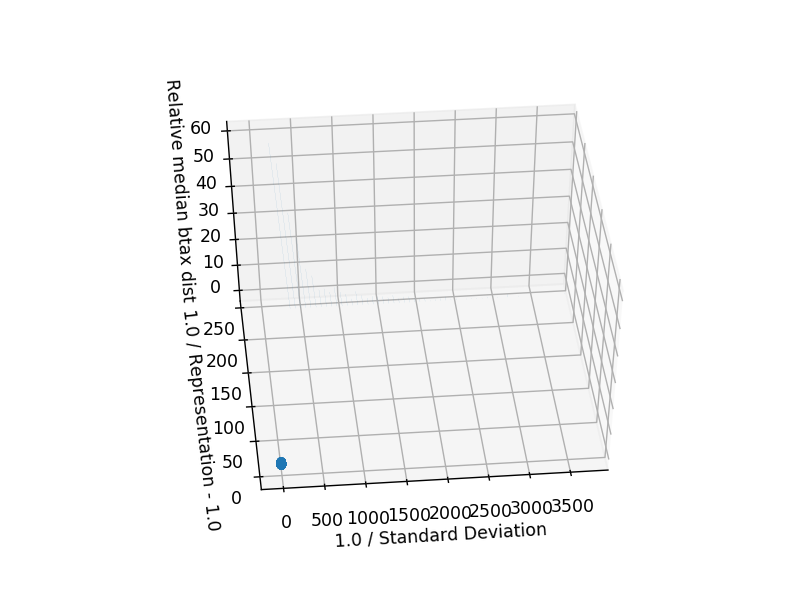

In [54]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(gtf_df_filt2["uniformity_std"],
           gtf_df_filt2["representation"],
           gtf_df_filt2["relative_median_btax_dist"])
ax.set_xlabel("1.0 / Standard Deviation")
ax.set_ylabel("1.0 / Representation - 1.0")
ax.set_zlabel("Relative median btax dist")
plt.show()

In [19]:
1.0/ pd.Series([1,2,3,np.nan])

0    1.000000
1    0.500000
2    0.333333
3         NaN
dtype: float64

In [124]:
!ls ../../../DEG/ECOLI_K12_orf_alignments



deg_essential-15.2.zip	   ECOLI_K12_MG_1655_ORF_alns.tar.xz
deg_nonessential-15.2.zip  ECOLI_K12_orf_alignments
ECOLI_K12_MG1655	   NC_004347.fasta
